### Задача uplift-моделирования

### Практический пример с соревнования с Kaggle

https://www.kaggle.com/davinwijaya/customer-retention

Импортируем нужные библиотеки и предобработаем данные:

In [1]:
%matplotlib inline

import pandas as pd; pd.set_option('display.max_columns', None)
from sklearn.model_selection import train_test_split

In [2]:
df = pd.read_csv('HW_data.csv')
df.rename(columns={'conversion' : 'target', 'offer' : 'treatment'}, inplace=True)
df.loc[(df['treatment'] == 'No Offer'), 'treatment'] = 0
df.loc[(df['treatment'] != 0), 'treatment'] = 1
df.head()

,recency,history,used_discount,used_bogo,zip_code,is_referral,channel,treatment,target
0,10,142.44,1,0,Surburban,0,Phone,1,0
1,6,329.08,1,1,Rural,1,Web,0,0
2,7,180.65,0,1,Surburban,1,Web,1,0
3,9,675.83,1,0,Rural,1,Web,1,0
4,2,45.34,1,0,Urban,0,Web,1,0


In [3]:
X_train, X_test, y_train, y_test = train_test_split(df.drop('target', 1), 
                                                    df['target'], random_state=0)

In [4]:
treat_train = X_train['treatment']
X_train = X_train.drop('treatment', 1)
treat_test = X_test['treatment']
X_test = X_test.drop('treatment', 1)

In [5]:
cat_features = ['zip_code', 'channel']
models_results = {
    'approach': [],
    'uplift@30%': []
}

### 1. Подходы с одной моделью
#### 1.1 Одна модель с признаком коммуникации
Самое простое и интуитивное решение: модель обучается одновременно на двух группах, при этом бинарный флаг коммуникации выступает в качестве дополнительного признака. Каждый объект из тестовой выборки скорим дважды: с флагом коммуникации равным 1 и равным 0. Вычитая вероятности по каждому наблюдению, получим искомы uplift.

![ab_split](uplift4.png "uplift4")

uplift@30%: 0.0587


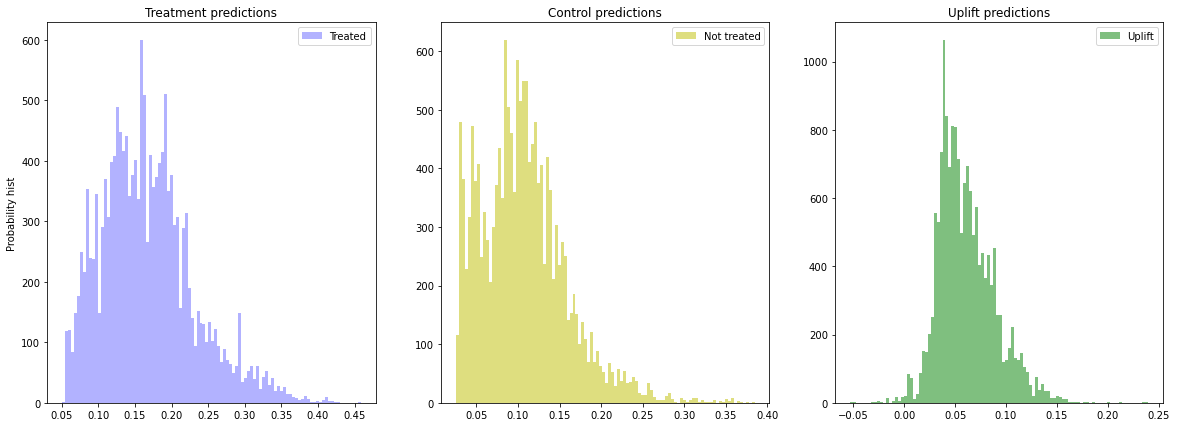

In [6]:
# Инструкция по установке пакета: https://github.com/maks-sh/scikit-uplift
# Ссылка на документацию: https://scikit-uplift.readthedocs.io/en/latest/
from sklift.metrics import uplift_at_k
from sklift.viz import plot_uplift_preds
from sklift.models import SoloModel

# sklift поддерживает любые модели, 
# которые удовлетворяют соглашениями scikit-learn
# Для примера воспользуемся catboost
from catboost import CatBoostClassifier


sm = SoloModel(CatBoostClassifier(iterations=20, thread_count=2, random_state=42, silent=True))
sm = sm.fit(X_train, y_train, treat_train, estimator_fit_params={'cat_features': cat_features})

uplift_sm = sm.predict(X_test)

sm_score = uplift_at_k(y_true=y_test, uplift=uplift_sm, treatment=treat_test, strategy='by_group', k=0.3)
print(f'uplift@30%: {sm_score:.4f}')

models_results['approach'].append('SoloModel')
models_results['uplift@30%'].append(sm_score)

# Получим условные вероятности выполнения целевого действия при взаимодействии для каждого объекта
sm_trmnt_preds = sm.trmnt_preds_
# И условные вероятности выполнения целевого действия без взаимодействия для каждого объекта
sm_ctrl_preds = sm.ctrl_preds_

# Отрисуем распределения вероятностей и их разность (uplift)
plot_uplift_preds(trmnt_preds=sm_trmnt_preds, ctrl_preds=sm_ctrl_preds);

Посмотрим на топ-признаки

In [7]:
# С той же легкостью можно обратиться к обученной модели.
# Например, чтобы построить важность признаков:
sm_fi = pd.DataFrame({
    'feature_name': sm.estimator.feature_names_,
    'feature_score': sm.estimator.feature_importances_
}).sort_values('feature_score', ascending=False).reset_index(drop=True)

sm_fi

,feature_name,feature_score
0,treatment,19.514123
1,is_referral,18.005875
2,used_bogo,13.953424
3,zip_code,10.815798
4,recency,10.020725
5,used_discount,9.757263
6,history,9.558841
7,channel,8.373951


#### 1.2 Трансформация классов
Достаточно интересный и математически подтвержденный подход к построению модели, представленный еще в 2012 году. Метод заключается в прогнозировании немного измененного таргета:

![ab_split](uplift5.png "uplift5")

![ab_split](uplift_client_types.png "uplift_client_types")

In [8]:
from sklift.models import ClassTransformation


ct = ClassTransformation(CatBoostClassifier(iterations=20, thread_count=2, random_state=42, silent=True))
ct = ct.fit(X_train, y_train, treat_train, estimator_fit_params={'cat_features': cat_features})

uplift_ct = ct.predict(X_test)

ct_score = uplift_at_k(y_true=y_test, uplift=uplift_ct, treatment=treat_test, strategy='by_group', k=0.3)

models_results['approach'].append('ClassTransformation')
models_results['uplift@30%'].append(ct_score)

<ipython-input-8-ce11d222af87>:5: UserWarning: It is recommended to use this approach on treatment balanced data. Current sample size is unbalanced.
  ct = ct.fit(X_train, y_train, treat_train, estimator_fit_params={'cat_features': cat_features})


#### 2.1 Две независимые модели
Как понятно из названия, подход заключается в моделировании условных вероятностей тестовой и контрольной групп отдельно. В статьях утверждается, что такой подход достаточно слабый, так как обе модели фокусируются на прогнозировании результата отдельно и поэтому могут пропустить "более слабые" различия в выборках.

![ab_split](uplift6.png "uplift6")

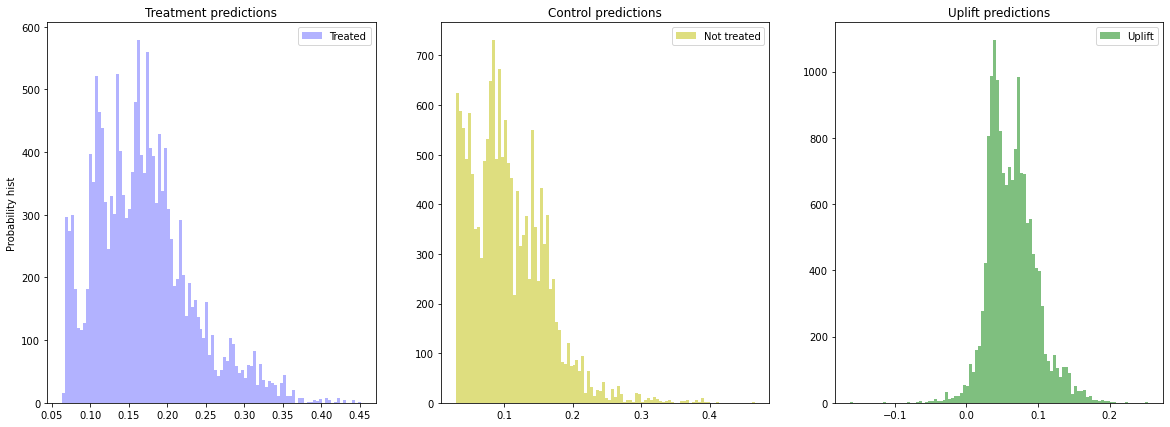

In [9]:
from sklift.models import TwoModels


tm = TwoModels(
    estimator_trmnt=CatBoostClassifier(iterations=20, thread_count=2, random_state=42, silent=True), 
    estimator_ctrl=CatBoostClassifier(iterations=20, thread_count=2, random_state=42, silent=True), 
    method='vanilla'
)
tm = tm.fit(
    X_train, y_train, treat_train,
    estimator_trmnt_fit_params={'cat_features': cat_features}, 
    estimator_ctrl_fit_params={'cat_features': cat_features}
)

uplift_tm = tm.predict(X_test)

tm_score = uplift_at_k(y_true=y_test, uplift=uplift_tm, treatment=treat_test, strategy='by_group', k=0.3)

models_results['approach'].append('TwoModels')
models_results['uplift@30%'].append(tm_score)

plot_uplift_preds(trmnt_preds=tm.trmnt_preds_, ctrl_preds=tm.ctrl_preds_);

Посмотрим на результаты

In [10]:
pd.DataFrame(data=models_results).sort_values('uplift@30%', ascending=False)

,approach,uplift@30%
2,TwoModels,0.067544
1,ClassTransformation,0.062556
0,SoloModel,0.058743


#### Вариант с деревом решений

In [11]:
X_train_tree = pd.concat([X_train.drop(['zip_code', 'channel'], 1), 
                          pd.get_dummies(X_train[['zip_code', 'channel']], prefix=['zip_code', 'channel'])], 1)

features = [col for col in X_train_tree]

In [12]:
# !git clone https://github.com/uber/causalml.git
# %cd causalml
# !pip install -r requirements.txt
# !python setup.py build_ext --inplace
# !python setup.py install

In [14]:
%%time
from IPython.display import Image
from causalml.inference.tree import UpliftTreeClassifier, UpliftRandomForestClassifier
from causalml.inference.tree import uplift_tree_string, uplift_tree_plot

uplift_model = UpliftTreeClassifier(max_depth=8, min_samples_leaf=200, min_samples_treatment=50,
                                    n_reg=100, evaluationFunction='KL', control_name='control')

uplift_model.fit(X_train_tree.values,
                 treatment=treat_train.map({1: 'treatment1', 0: 'control'}).values,
                 y=y_train)

graph = uplift_tree_plot(uplift_model.fitted_uplift_tree, features)
Image(graph.create_png())

InvocationException: GraphViz's executables not found

### Домашнее задание

1. скачать набор данных маркетинговых кампаний отсюда https://www.kaggle.com/davinwijaya/customer-retention
2. там поле conversion - это целевая переменная, а offer - коммуникация. Переименовать поля (conversion -> target, offer -> treatment) и привести поле treatment к бинарному виду (1 или 0, т.е было какое-то предложение или нет) - значение No Offer означает отсутствие коммуникации, а все остальные - наличие.
3. сделать разбиение набора данных не тренировочную и тестовую выборки
4. сделать feature engineering на ваше усмотрение (допускается свобода выбора методов)
5. провести uplift-моделирование 3 способами: одна модель с признаком коммуникации (S learner), модель с трансформацией таргета (трансформация классов п. 2. 1) и вариант с двумя независимыми моделями
6. в конце вывести единую таблицу сравнения метрик uplift@10%, uplift@20% этих 3 моделей
7. построить модель UpliftTreeClassifier и попытаться описать словами полученное дерево
8. (опционально) для модели S learner (модель с дополнительным признаком коммуникации) построить зависимость таргета (конверсии - поле conversion) от значения uplift: 1) сделать прогноз и получить uplift для тестовой выборки 2) отсортировать тестовую выборку по uplift по убыванию 3) разбить на децили (pandas qcut вам в помощь) 4) для каждого дециля посчитать среднюю conversion
9. (опционально) построить модель UpliftRandomForestClassifier и попытаться описать словами полученное дерево

### Ссылки

1. https://towardsdatascience.com/a-quick-uplift-modeling-introduction-6e14de32bfe0
2. https://habr.com/ru/company/ru_mts/blog/485980/#reference1
3. https://en.wikipedia.org/wiki/Uplift_modelling
4. https://www.youtube.com/watch?v=yFQAIJBYXI0
5. https://www.youtube.com/watch?v=jCUcYiBK03I
6. https://www.uplift-modeling.com/en/latest/
7. https://arxiv.org/pdf/1809.04559.pdf
8. https://catboost.ai/docs/concepts/about.html